# Q-learning 

In [ ]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    !pip install -U gymnasium pygame swig
    !pip install -U moviepy==1.0.3
    !pip install gymnasium[box2d]


In [2]:
import numpy as np
rng = np.random.default_rng()
import matplotlib.pyplot as plt
import os

import gymnasium as gym
print("gym version:", gym.__version__)

from moviepy.editor import ImageSequenceClip, ipython_display

class GymRecorder(object):
    """
    Simple wrapper over moviepy to generate a .gif with the frames of a gym environment.
    
    The environment must have the render_mode `rgb_array_list`.
    """
    def __init__(self, env):
        self.env = env
        self._frames = []

    def record(self, frames):
        "To be called at the end of an episode."
        for frame in frames:
            self._frames.append(np.array(frame))

    def make_video(self, filename):
        "Generates the gif video."
        directory = os.path.dirname(os.path.abspath(filename))
        if not os.path.exists(directory):
            os.mkdir(directory)
        self.clip = ImageSequenceClip(list(self._frames), fps=self.env.metadata["render_fps"])
        self.clip.write_gif(filename, fps=self.env.metadata["render_fps"], loop=0)
        del self._frames
        self._frames = []

def running_average(x, N):
    kernel = np.ones(N) / N
    return np.convolve(x, kernel, mode='same')

gym version: 1.0.0


In this short exercise, we are going to apply **Q-learning** on the Taxi environment used last time for MC control.

As a reminder, Q-learning updates the Q-value of a state-action pair **after each transition**, using the update rule:

$$\Delta Q(s_t, a_t) = \alpha \, (r_{t+1} + \gamma \, \max_{a'} \, Q(s_{t+1}, a') - Q(s_t, a_t))$$

**Q:** Update the class you designed for online MC in the last exercise so that it implements Q-learning. 

The main difference is that the `update()` method has to be called after each step of the episode, not at the end. It simplifies a lot the code too (no need to iterate backwards on the episode).

You can use the following parameters at the beginning, but feel free to change them:

* Discount factor $\gamma = 0.9$. 
* Learning rate $\alpha = 0.1$.
* Epsilon-greedy action selection, with an initial exploration parameter of 1.0 and an exponential decay of $10^{-5}$ after each update (i.e. every step!).
* A total number of episodes of 20000.

Keep the general structure of the class: `train()` for the main loop, `test()` to run one episode without exploration, etc. 

Plot the training and test performance in the end and render the learned deterministic policy for one episode.

*Note:* if $s_{t+1}$ is terminal (`done` is true after the transition), the target should not be $r_{t+1} + \gamma \, \max_{a'} \, Q(s_{t+1}, a')$, but simply $r_{t+1}$ as there is no next action.

In [3]:
class QLearningAgent:
    """
    Q-learning agent.
    """
    
    def __init__(self, env, gamma, epsilon, decay_epsilon, alpha):
        """
        :param env: gym-like environment
        :param gamma: discount factor
        :param epsilon: exploration parameter
        :param decay_epsilon: exploration decay parameter
        :param alpha: learning rate
        """
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        self.decay_epsilon = decay_epsilon
        self.alpha = alpha
        
        # Q_table
        self.Q = np.zeros([self.env.observation_space.n, self.env.action_space.n])
    
    def act(self, state):
        "Returns an action using epsilon-greedy action selection."
        
        action = rng.choice(np.where(self.Q[state, :] == self.Q[state, :].max())[0])
        
        if rng.random() < self.epsilon:
            action = self.env.action_space.sample() 
        
        return action
    
    def update(self, state, action, reward, next_state, done):
        "Updates the agent using a single transition."
        
        # Bellman target
        target = reward
        
        if not done:
            target += self.gamma * self.Q[next_state, :].max()
        
        # Update the Q-value
        self.Q[state, action] += self.alpha * (target - self.Q[state, action])
            
        # Decay epsilon
        self.epsilon = self.epsilon * (1 - self.decay_epsilon)
            
    
    def train(self, nb_episodes, recorder=None):
        "Runs the agent on the environment for nb_episodes. Returns the list of obtained returns."

        # Returns
        returns = []
        steps = []

        # Fixed number of episodes
        for episode in range(nb_episodes):

            # Reset
            state, info = self.env.reset()
            done = False
            nb_steps = 0

            # Store rewards
            return_episode = 0.0

            # Sample the episode
            while not done:

                # Select an action 
                action = self.act(state)

                # Perform the action
                next_state, reward, terminal, truncated, info = self.env.step(action)
                
                # End of the episode
                done = terminal or truncated

                # Learn from the transition
                self.update(state, action, reward, next_state, done)

                # Go in the next state
                state = next_state

                # Increment time
                nb_steps += 1
                return_episode += reward 
                

            # Record at the end of the episode
            if recorder is not None and episode == nb_episodes -1:
                recorder.record(self.env.render())

            # Store info
            returns.append(return_episode)
            steps.append(nb_steps)
        
            
        return returns, steps
    
    def test(self, recorder=None):
        "Performs a test episode without exploration."
        previous_epsilon = self.epsilon
        self.epsilon = 0.0
        
        # Reset
        state, info = self.env.reset()
        done = False
        nb_steps = 0
        return_episode= 0

        # Sample the episode
        while not done:
            action = self.act(state)
            next_state, reward, terminal, truncated, info = self.env.step(action)
            done = terminal or truncated
            return_episode += reward
            state = next_state
            nb_steps += 1
            
        self.epsilon = previous_epsilon
            
        if recorder is not None:
            recorder.record(self.env.render())

        return return_episode, nb_steps

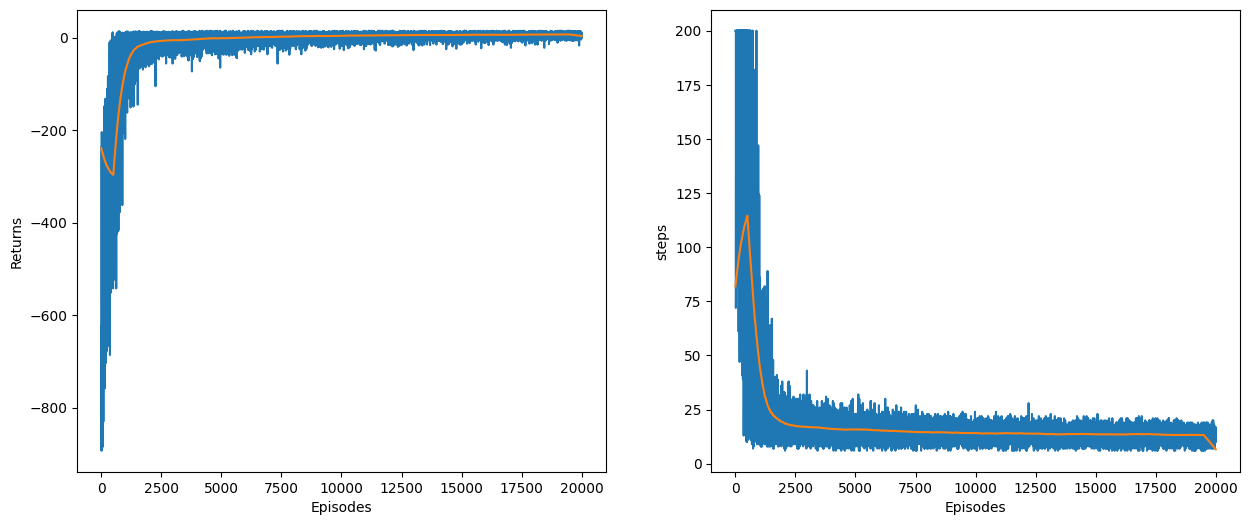

In [4]:
# Parameters
gamma = 0.9
epsilon = 1.0
decay_epsilon = 1e-5
alpha = 0.1
nb_episodes = 20000

# Create the environment
env = gym.make("Taxi-v3")

# Create the agent
agent = QLearningAgent(env, gamma, epsilon, decay_epsilon, alpha)

# Train the agent 
returns, steps = agent.train(nb_episodes)

# Plot training returns
plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.plot(returns)
plt.plot(running_average(returns, 1000))
plt.xlabel("Episodes")
plt.ylabel("Returns")
plt.subplot(122)
plt.plot(steps)
plt.plot(running_average(steps, 1000))
plt.xlabel("Episodes")
plt.ylabel("steps")
plt.show()

Test performance 8.027


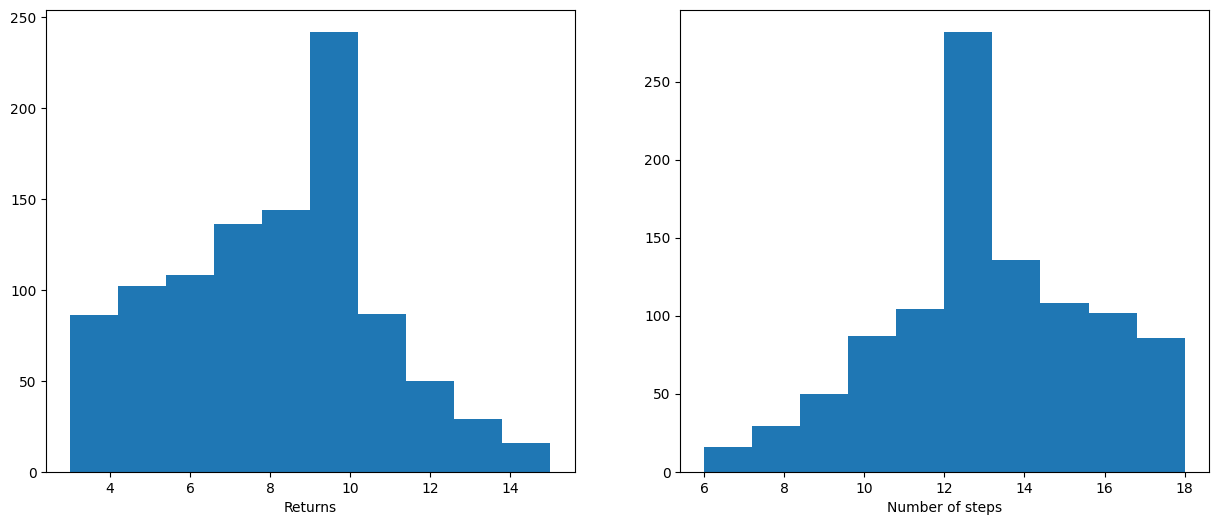

In [5]:
# Test the agent for 1000 episodes
test_returns = []
test_steps = []
for episode in range(1000):
    return_episode, nb_steps = agent.test()
    test_returns.append(return_episode)
    test_steps.append(nb_steps)
print("Test performance", np.mean(test_returns))

plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.hist(test_returns)
plt.xlabel("Returns")
plt.subplot(122)
plt.hist(test_steps)
plt.xlabel("Number of steps")
plt.show()

In [ ]:
env = gym.make("Taxi-v3", render_mode="rgb_array_list")
recorder = GymRecorder(env)
agent.env = env

return_episode, nb_steps = agent.test(recorder)

video = "videos/taxi-trained-td.gif"
recorder.make_video(video)
ipython_display(video, loop=0, autoplay=1)

**Q:** Compare the performance of Q-learning to online MC. Experiment with parameters (gamma, epsilon, alpha, etc.).

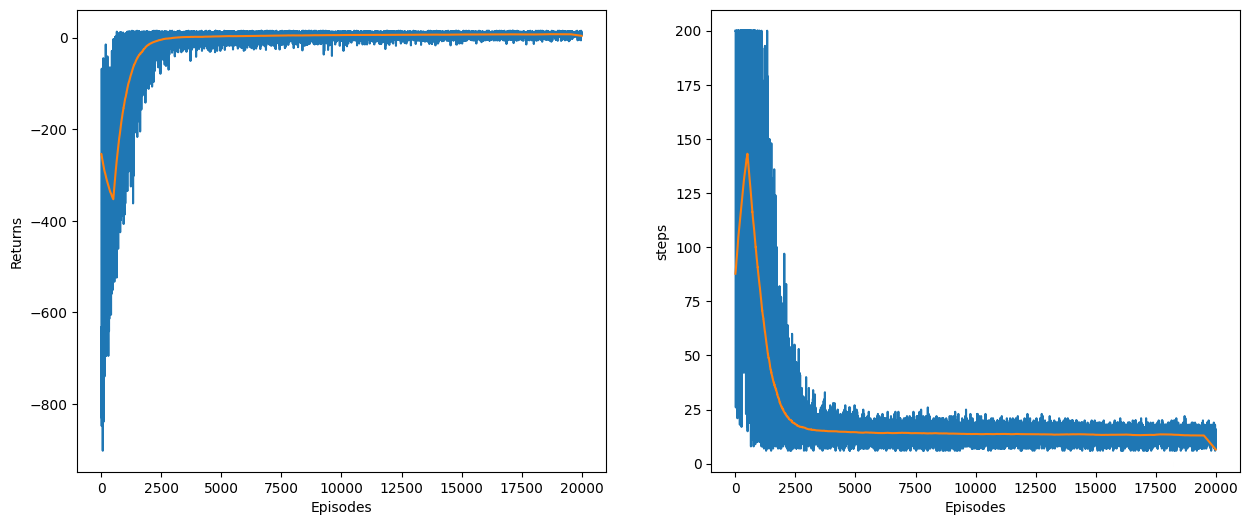

In [7]:
# Parameters
gamma = 1.0
epsilon = 1.0
decay_epsilon = 1e-5
alpha = 0.05
nb_episodes = 20000

# Create the environment
env = gym.make("Taxi-v3")

# Create the agent
agent = QLearningAgent(env, gamma, epsilon, decay_epsilon, alpha)

# Train the agent 
returns, steps = agent.train(nb_episodes)

# Plot training returns
plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.plot(returns)
plt.plot(running_average(returns, 1000))
plt.xlabel("Episodes")
plt.ylabel("Returns")
plt.subplot(122)
plt.plot(steps)
plt.plot(running_average(steps, 1000))
plt.xlabel("Episodes")
plt.ylabel("steps")
plt.show()

Test performance 7.922


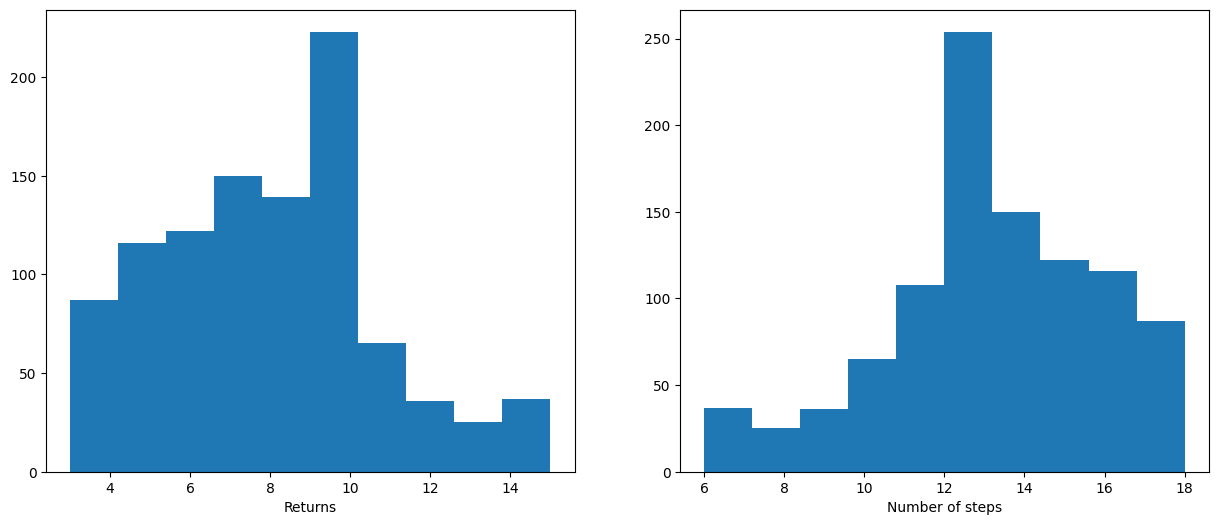

: 

In [8]:
# Test the agent for 1000 episodes
test_returns = []
test_steps = []
for episode in range(1000):
    return_episode, nb_steps = agent.test()
    test_returns.append(return_episode)
    test_steps.append(nb_steps)
print("Test performance", np.mean(test_returns))

plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.hist(test_returns)
plt.xlabel("Returns")
plt.subplot(122)
plt.hist(test_steps)
plt.xlabel("Number of steps")
plt.show()

**A:** Q-learning accepts much higher values of gamma than MC, because the returns have a much lower variance. With the right parameters, Q-learning can learn much faster than MC.